We are interested in generating meaningful interpolations and extrapolations based on the learned letterforms. therefore we start by evaluating the model's ability to interpolate between different variations in the same writing system such as weight (thickness), size, rotation, slant and style (font family). we then explore the extrapolation capabilities between letterforms of different writing systems.

We compare models with different latent dimensions and other hyperparameters. we also compare the results of the models trained on different datasets with different levels of augmentation.

In [28]:
import torch
import os
import matplotlib.pyplot as plt

use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
MODELS_DIR = './results/models/'

%matplotlib inline
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Pre-Trained Models

In [29]:
from src.vae import VariationalAutoencoder
from configs.config import vae_config
from configs.config import dotdict

def get_model_name(conf, ds_type, letter):
    latent_dims, capacity, beta = conf.latent_dims, conf.capacity, conf.variational_beta
    model_name = f"vae_{ds_type}_{letter}_{latent_dims}_{capacity}_{beta}"
    return model_name

def load_vae(conf, ds_type, letter, device):
    vae = VariationalAutoencoder(conf)
    model_name = get_model_name(conf, ds_type, letter)
    # load on cpu
    vae.load_state_dict(torch.load(MODELS_DIR + model_name + ".pt", map_location=device))
    return vae

example_config = dotdict({
    'latent_dims': 2,
    'capacity': 64,
    'variational_beta': 1.0
})

example_letter = 'aleph'

example_vae = load_vae(example_config, 'base', example_letter, device)

In [30]:
# hyperparameter ranges for model evaluation
latent_dims = [2, 3]
capacity = [64, 128]
variational_beta = [0.1, 0.5, 1.0, 2.0]
letters = ["aleph", "shin", "mem"]
ds_types = ["base"]

In [31]:
import itertools 

models = {}

for ds_type, letter, latent_dim, cap, beta in itertools.product(ds_types, letters, latent_dims, capacity, variational_beta):
    vae_config = dotdict({
        'latent_dims': latent_dim,
        'capacity': cap,
        'variational_beta': beta,
    })
    model = VariationalAutoencoder(vae_config)
    model_name = get_model_name(vae_config, ds_type, letter)
    model.load_state_dict(torch.load(os.path.join(MODELS_DIR, model_name + ".pt")))
    model.eval()
    models[model_name] = model

Load base dataset, this is a dataset where all letters are centered, not rotated and with a fixed size.

In [32]:
from torch.utils.data import DataLoader
from torchvision import transforms
from src.datasets import GraphemesDataset
data_dir = "datasets/base_dataset/"

img_transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = GraphemesDataset(data_dir, test_size=0, by_letter=example_letter, transform=img_transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


In [33]:
# convert all images to their latent representation using the encoder

# images will be a list of all images in the dataset in the same order as the labels and latent_representations lists
# you should add all images from all batches to the list and make sure to
# convert it to PIL images of 28 x 28

from PIL import Image        


def get_latent_representation(vae, dataloader, device):
    images = []
    reconstructions = []
    latent_representations = []
    labels = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):

            for tensor in x:
                # Remove the batch dimension and convert the tensor to a numpy array
                image_np = tensor.squeeze().cpu().numpy()
                # Convert numpy array to PIL image
                pil_image = Image.fromarray((image_np * 255).astype('uint8'), mode='L')
                images.append(pil_image)

            x = x.to(device)
            mu, logvar = vae.encoder(x)
            latent_representations.append(mu)
            image_recon = vae.decoder(mu)
            reconstructions.append(image_recon)
            labels.append(y)

    latent_representations = torch.cat(latent_representations).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    reconstructions = torch.cat(reconstructions).cpu().numpy()

    pil_reconstructions = []
    for img_tensor in reconstructions:
        img_np = img_tensor.squeeze() * 255
        pil_img = Image.fromarray(img_np.astype('uint8'), mode='L')
        pil_reconstructions.append(pil_img)

    return images, labels, latent_representations, pil_reconstructions

images, y, z, reconstructions = get_latent_representation(example_vae, dataloader, device)

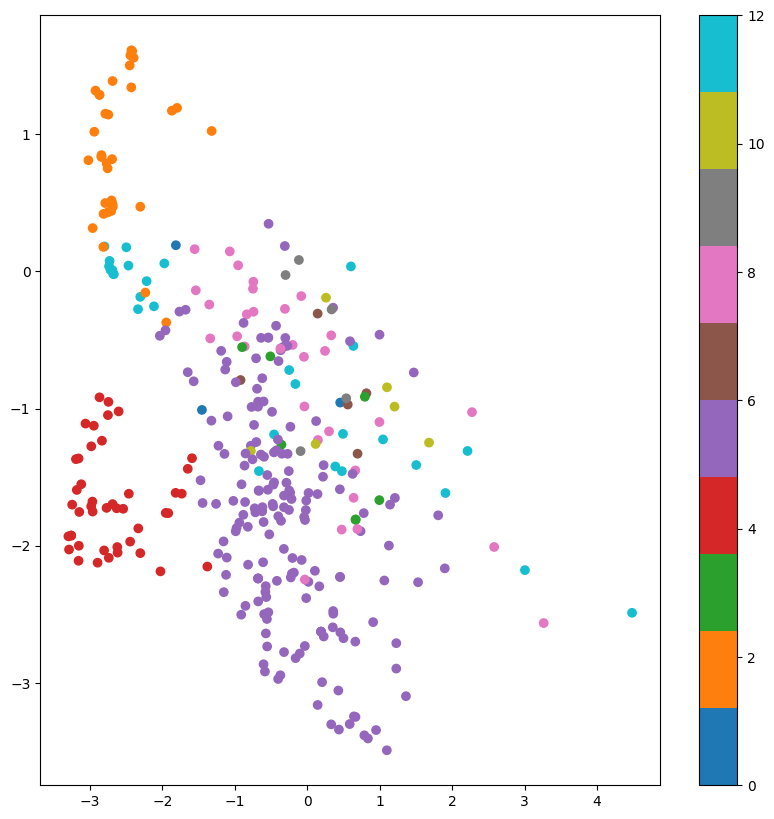

In [34]:
# if latent dims is 2 or 3, then plot the latent space

if example_config.latent_dims == 2:
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
    plt.colorbar()
    plt.show()

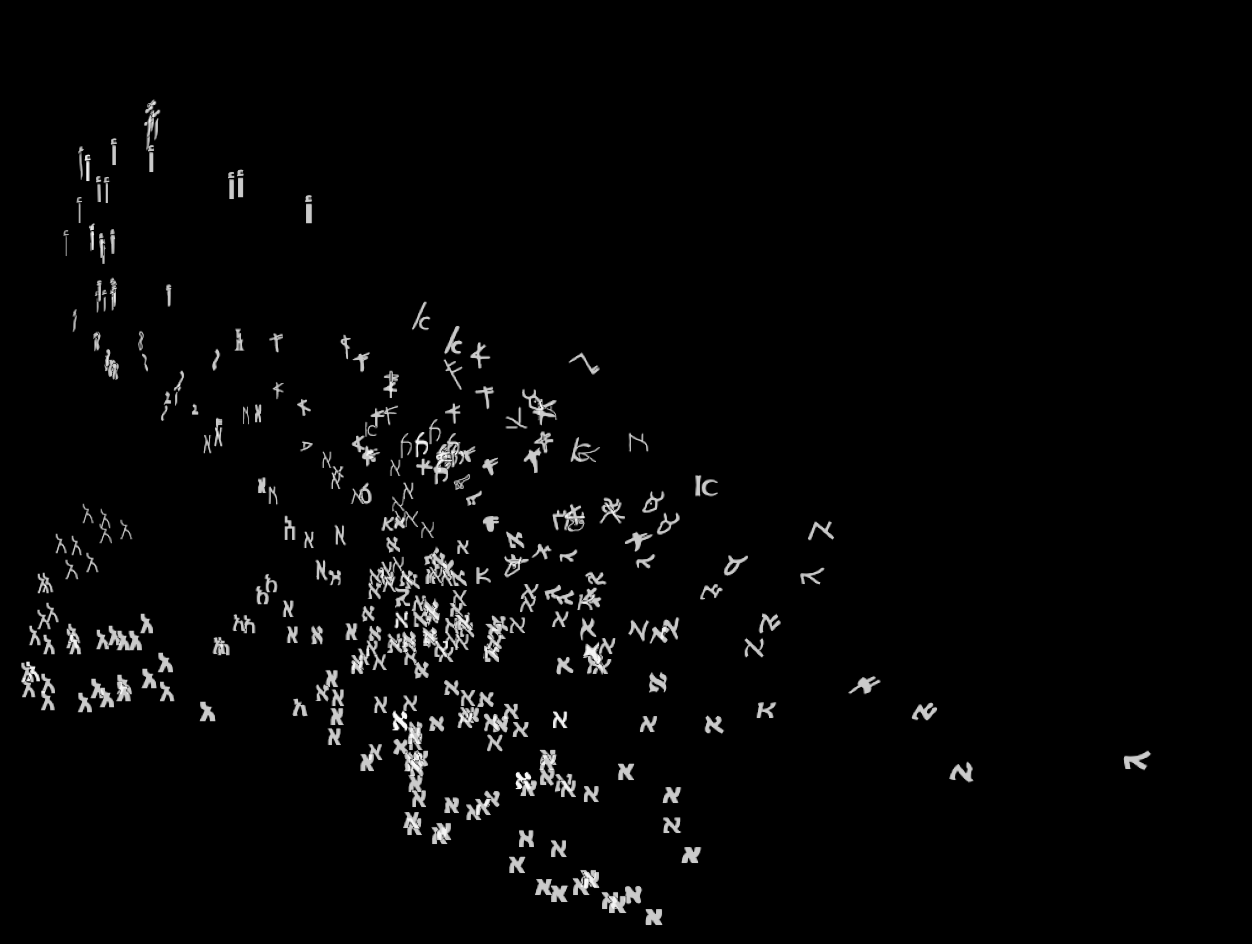

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_images_with_coordinates(images, coordinates, width=1000, height=750, max_dim=100):
    normalized_x, normalized_y = coordinates[:, 0], coordinates[:, 1]
    normalized_x = (normalized_x - np.min(normalized_x)) / (np.max(normalized_x) - np.min(normalized_x))
    normalized_y = (normalized_y - np.min(normalized_y)) / (np.max(normalized_y) - np.min(normalized_y))

    plt.figure(figsize=(16, 12), facecolor='black')

    for grapheme, norm_x, norm_y in zip(images, normalized_x, normalized_y):
        grapheme_cv2 = cv2.cvtColor(np.array(grapheme), cv2.COLOR_RGBA2BGRA)

        gray = cv2.cvtColor(grapheme_cv2, cv2.COLOR_BGRA2GRAY)
        _, alpha = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

        b, g, r, _ = cv2.split(grapheme_cv2)
        rgba = [b, g, r, alpha]
        grapheme_no_bg = cv2.merge(rgba, 4)

        x_coord = int((width - max_dim) * norm_x)
        y_coord = int((height - max_dim) * norm_y)

        plt.imshow(grapheme_no_bg, extent=[x_coord, x_coord + grapheme.width, y_coord, y_coord + grapheme.height], alpha=0.8)

    plt.xlim(0, width)
    plt.ylim(0, height)

    plt.axis('off')
    plt.grid(False)

    plt.show()

# Example usage
plot_images_with_coordinates(images, z)


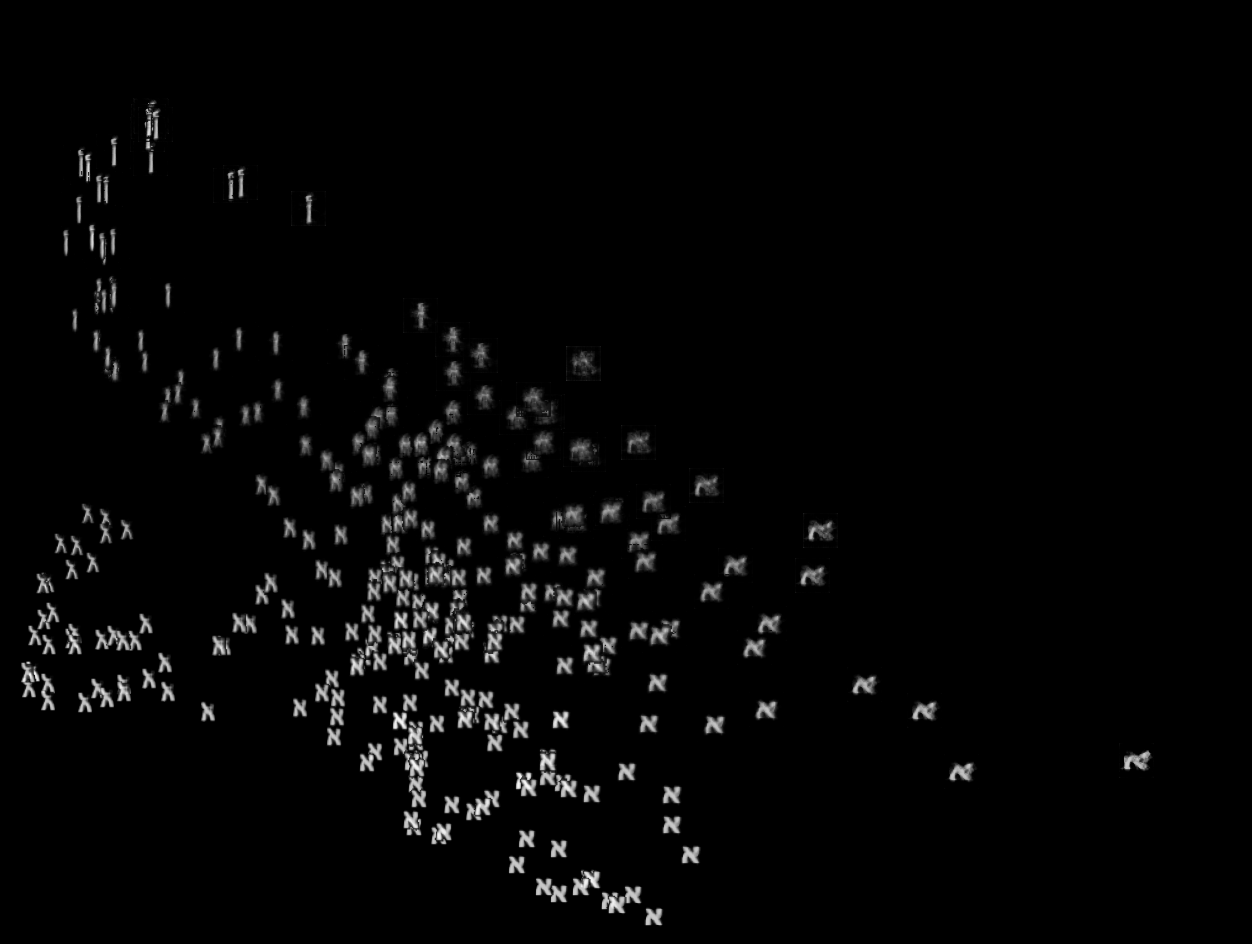

In [36]:
plot_images_with_coordinates(reconstructions, z)
